<p>
    <font face="Microsoft YaHei" size=3>Prepared by "Big Data Analytics", Fall 2020 [Group 1]
        <font style="color:#a569bd">SWE1709044 Cai Zijian</font>,
        <font style="color:#3498db">SWE1709267 Liu Yanfeng</font>,<br>
        <font style="color:#52be80">SWE1709346 Sun Ruitao</font>,
        <font style="color:#ce5687">SWE1709425 Xu Jiayun</font>,
        <font style="color:#92a029">SWE1709509 Zhang Xinming</font>,
        <font style="color:#0927a2">SWE1709520 Zhang Zhichao</font>
    </font>
</p>
<HR style="border:1 dashed #987cb9" width="100%" color=#987cb9 SIZE=1></HR>

# **Question 5 - Mushroom Classification**

In [1]:
import pandas as pd
import numpy as np 
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark=SparkSession.builder.getOrCreate()

## **Step 1 - Load Dataset**

In [2]:
# Load dataset into Pandas dataframe
pandas_df = pd.read_csv('./mushrooms.csv')
pandas_df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


## **Step 2 - Convert to Spark Dataframe**

In [3]:
# Convert to Spark dataframe
df = spark.createDataFrame(pandas_df)
df.printSchema()

root
 |-- class: string (nullable = true)
 |-- cap-shape: string (nullable = true)
 |-- cap-surface: string (nullable = true)
 |-- cap-color: string (nullable = true)
 |-- bruises: string (nullable = true)
 |-- odor: string (nullable = true)
 |-- gill-attachment: string (nullable = true)
 |-- gill-spacing: string (nullable = true)
 |-- gill-size: string (nullable = true)
 |-- gill-color: string (nullable = true)
 |-- stalk-shape: string (nullable = true)
 |-- stalk-root: string (nullable = true)
 |-- stalk-surface-above-ring: string (nullable = true)
 |-- stalk-surface-below-ring: string (nullable = true)
 |-- stalk-color-above-ring: string (nullable = true)
 |-- stalk-color-below-ring: string (nullable = true)
 |-- veil-type: string (nullable = true)
 |-- veil-color: string (nullable = true)
 |-- ring-number: string (nullable = true)
 |-- ring-type: string (nullable = true)
 |-- spore-print-color: string (nullable = true)
 |-- population: string (nullable = true)
 |-- habitat: string 

## **Step 3 - Convert String to Numerical Value**

In [4]:
# Convert mushroom features in String type into Integer type
col_name = set(df.columns)
indexers = [StringIndexer(inputCol = column, outputCol = "_" + column).fit(df) for column in list(col_name)]
pipeline = Pipeline(stages = indexers)
df = pipeline.fit(df).transform(df)
df = df.select([column for column in df.columns if column not in col_name])

In [5]:
# Display converted data type
df.printSchema()

root
 |-- _veil-type: double (nullable = false)
 |-- _odor: double (nullable = false)
 |-- _cap-shape: double (nullable = false)
 |-- _stalk-surface-above-ring: double (nullable = false)
 |-- _cap-color: double (nullable = false)
 |-- _stalk-color-above-ring: double (nullable = false)
 |-- _stalk-color-below-ring: double (nullable = false)
 |-- _ring-number: double (nullable = false)
 |-- _population: double (nullable = false)
 |-- _veil-color: double (nullable = false)
 |-- _gill-spacing: double (nullable = false)
 |-- _gill-color: double (nullable = false)
 |-- _ring-type: double (nullable = false)
 |-- _gill-attachment: double (nullable = false)
 |-- _bruises: double (nullable = false)
 |-- _stalk-surface-below-ring: double (nullable = false)
 |-- _spore-print-color: double (nullable = false)
 |-- _gill-size: double (nullable = false)
 |-- _stalk-shape: double (nullable = false)
 |-- _class: double (nullable = false)
 |-- _cap-surface: double (nullable = false)
 |-- _stalk-root: dou

## **Step 4 - Generate Feature Vector**

In [6]:
# Generate the feature vector
col_name = df.columns
col_name.remove("_class")
df_assembler = VectorAssembler(inputCols=col_name, outputCol="features") 
df = df_assembler.transform(df)

## **Step 5 - Split into Training & Testing Set**

In [7]:
# Split the dataset into training set and testing set, with 0.6:0.4 ratio
model_df = df.select(['features','_class'])
train_df, test_df = model_df.randomSplit([0.6,0.4])

## **Step 6 - Decision Tree Model**

In [28]:
#Decision Tree Classifier Model
dt = DecisionTreeClassifier(maxDepth=3, labelCol="_class", featuresCol="features")
model = dt.fit(train_df)

predictions = model.transform(test_df)
predictions.select("prediction", "_class", "features").show()

evaluator = MulticlassClassificationEvaluator(
        labelCol="_class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy = %g " %  (accuracy))
print(model)

+----------+------+--------------------+
|prediction|_class|            features|
+----------+------+--------------------+
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
+----------+------+--------------------+
only showing top

## **Step 7 - Random Forest Model**

In [9]:
# Random Forest Classifier Model
rf = RandomForestClassifier(labelCol="_class",featuresCol="features")
model = rf.fit(train_df)

predictions = model.transform(test_df)
predictions.select("prediction", "_class", "features").show()

evaluator = MulticlassClassificationEvaluator(labelCol="_class", 
                            predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy = %g" % (accuracy))
print(model)

+----------+------+--------------------+
|prediction|_class|            features|
+----------+------+--------------------+
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
+----------+------+--------------------+
only showing top

## **Step 8 - Gradient-boosted Tree Model**

In [10]:
# Gradient-boosted Tree Classifier Model
gbt = GBTClassifier(maxIter=10, labelCol="_class", featuresCol="features")
model = gbt.fit(train_df)

predictions = model.transform(test_df)
predictions.select("prediction", "_class", "features").show()

evaluator = MulticlassClassificationEvaluator(labelCol="_class", 
                               predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy = %g" % (accuracy))
print(model)

+----------+------+--------------------+
|prediction|_class|            features|
+----------+------+--------------------+
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
+----------+------+--------------------+
only showing top

## **Step 9 - Linear Support Vector Machine Model**

In [11]:
# Linear Support Vector Machine Model
lsvc = LinearSVC(labelCol="_class", featuresCol="features")
lsvcModel = lsvc.fit(train_df)

predictions = lsvcModel.transform(test_df)
predictions.select("prediction", "_class", "features").show()

evaluator = BinaryClassificationEvaluator(labelCol="_class", rawPredictionCol="prediction", 
                                metricName="areaUnderROC")
accuracy = evaluator.evaluate(predictions)

print("Accuracy = %g" %  (accuracy))
print(lsvcModel)

+----------+------+--------------------+
|prediction|_class|            features|
+----------+------+--------------------+
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
+----------+------+--------------------+
only showing top

## **Step 10 - Naive Bayes Model**

In [12]:
# Naive Bayes Model 
nb = NaiveBayes(labelCol="_class", featuresCol="features")
model = nb.fit(train_df)

predictions = model.transform(test_df)
predictions.select("prediction", "_class", "features").show()

evaluator = MulticlassClassificationEvaluator(labelCol="_class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy = %g" % (accuracy))
print(model)

+----------+------+--------------------+
|prediction|_class|            features|
+----------+------+--------------------+
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       1.0|   0.0|(22,[1,2,4,8,11,1...|
|       1.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
+----------+------+--------------------+
only showing top

## **Step 11 - Multilayer Perceptron Model (2 Dense Layers)**

In [13]:
# Multilayer Perceptron Classifier Model with 2 Dense Layers
layers = [22, 2]

trainer = MultilayerPerceptronClassifier(layers=layers, labelCol="_class")
model = trainer.fit(train_df)

predictions = model.transform(test_df)
predictions.select("prediction", "_class", "features").show()

evaluator = MulticlassClassificationEvaluator(labelCol="_class", 
                        predictionCol="prediction",metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy = %g" % accuracy)
print(model)

+----------+------+--------------------+
|prediction|_class|            features|
+----------+------+--------------------+
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
+----------+------+--------------------+
only showing top

## **Step 12 - Multilayer Perceptron Model (3 Dense Layers)**

In [14]:
# Multilayer Perceptron Classifier Model with 3 Dense Layers
layers = [22, 9 ,2]

trainer = MultilayerPerceptronClassifier(layers=layers, labelCol="_class")
model = trainer.fit(train_df)

predictions = model.transform(test_df)
predictions.select("prediction", "_class", "features").show()

evaluator = MulticlassClassificationEvaluator(labelCol="_class", 
                            predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy = %g" % accuracy)
print(model)

+----------+------+--------------------+
|prediction|_class|            features|
+----------+------+--------------------+
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
|       0.0|   0.0|(22,[1,2,4,8,11,1...|
+----------+------+--------------------+
only showing top

## **Step 13 - Convolutional Neural Network Model**

### TensorflowOnSpark configuration issue still cannot be solved... So currently only runs on Tensorflow

In [15]:
from sklearn import preprocessing
import seaborn as sns
from pylab import plot, show
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D

In [16]:
# Convert Spark Datafram back to Pandas Dataframe
pd_df = df.toPandas()
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   _veil-type                 8124 non-null   float64
 1   _odor                      8124 non-null   float64
 2   _cap-shape                 8124 non-null   float64
 3   _stalk-surface-above-ring  8124 non-null   float64
 4   _cap-color                 8124 non-null   float64
 5   _stalk-color-above-ring    8124 non-null   float64
 6   _stalk-color-below-ring    8124 non-null   float64
 7   _ring-number               8124 non-null   float64
 8   _population                8124 non-null   float64
 9   _veil-color                8124 non-null   float64
 10  _gill-spacing              8124 non-null   float64
 11  _gill-color                8124 non-null   float64
 12  _ring-type                 8124 non-null   float64
 13  _gill-attachment           8124 non-null   float

In [21]:
# X1, X2 to form X stands for Feature Columns, y for Label Conlumn 
X1 = pd_df.iloc[:, 0:19].values
X2 = pd_df.iloc[:, 20:23].values
y = pd_df.iloc[:, 19:20].values

X =  np.column_stack((X1, X2))

# add 3 column to 22 == 25 (2D image)
addzero = np.zeros(len(X))
X = np.column_stack((X, addzero))
X = np.column_stack((X, addzero))
X = np.column_stack((X, addzero))

In [22]:
# Reshape into 5*5 image
X = X.reshape((len(X), 5, 5, 1))
print(X.shape)

(8124, 5, 5, 1)


In [23]:
# Split into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

#####################################  CNN Model Architecture 
model = keras.Sequential([
keras.layers.Conv2D(96, (2, 2), activation='relu', input_shape=(5, 5, 1)),
keras.layers.MaxPooling2D((2, 2)),
keras.layers.Flatten(),
keras.layers.Dropout(0.02),
keras.layers.Activation('relu'),
keras.layers.Dense(2),
keras.layers.Activation('softmax')
])
#####################################

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 4, 4, 96)          480       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 96)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 384)               0         
_________________________________________________________________
activation_2 (Activation)    (None, 384)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 770       
_________________________________________________________________
activation_3 (Activation)    (None, 2)                

In [24]:
# Train and evaluate the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=10, epochs=20, validation_split=0.2, shuffle=True)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/20
488/488 [==============================] - 3s 4ms/step - loss: 0.4220 - accuracy: 0.8395 - val_loss: 0.2368 - val_accuracy: 0.9204
Epoch 2/20
488/488 [==============================] - 1s 3ms/step - loss: 0.2041 - accuracy: 0.9353 - val_loss: 0.1736 - val_accuracy: 0.9500
Epoch 3/20
488/488 [==============================] - 3s 5ms/step - loss: 0.1600 - accuracy: 0.9491 - val_loss: 0.1499 - val_accuracy: 0.9508
Epoch 4/20
488/488 [==============================] - 3s 7ms/step - loss: 0.1116 - accuracy: 0.9607 - val_loss: 0.1095 - val_accuracy: 0.9737
Epoch 5/20
488/488 [==============================] - 3s 6ms/step - loss: 0.0963 - accuracy: 0.9709 - val_loss: 0.0903 - val_accuracy: 0.9811
Epoch 6/20
488/488 [==============================] - 1s 3ms/step - loss: 0.0743 - accuracy: 0.9779 - val_loss: 0.0824 - val_accuracy: 0.9844
Epoch 7/20
488/488 [==============================] - 1s 2ms/step - loss: 0.0647 - accuracy: 0.9860 - val_loss: 0.0745 - val_accuracy: 0.9844
Epoch 

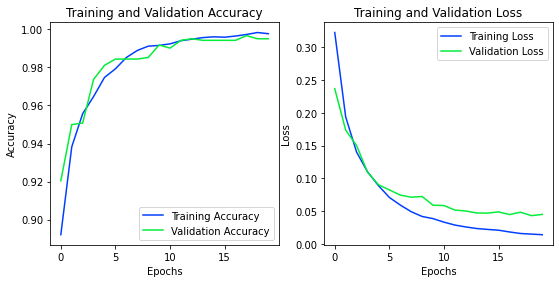

In [25]:
# Draw the Accuracy and Loss Chart againt epoch number
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(9, 9))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
